In [1]:
# TensorFlow and tf.keras
import tensorflow as tf

import keras
import keras.backend
from keras import layers
from keras import models
from keras import optimizers
import keras.utils
import pandas as pd

print(tf.__version__)

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
#import h5py
import math
import time
import sklearn
from sklearn.utils import shuffle

import innvestigate
import innvestigate.utils as iutils

import os

/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passing (type, 1) or 

1.13.1


Using TensorFlow backend.


In [2]:
def dataProcessing(dataset):
    data = np.load(dataset)
    images=np.array(data['jetImages'], dtype=np.float64).reshape(len(data['jetImages']),16,16,1)
    eta=np.array(data['jetEta'], dtype=np.float64)
    pt=np.array(data['jetPt'], dtype=np.float64)
    phi=np.array(data['jetPhi'], dtype=np.float16)
    tau21=np.array(data['tau21'], dtype=np.float64)
    jetpull=np.array(np.abs(data['jetpull']/math.pi), dtype=np.float64)
    labels=np.array(data['labels'], dtype=np.int16)
    n_ch=np.array(data['chMult'], dtype=np.int16)
    n_nh=np.array(data['neutMult'], dtype=np.int16)
    n_gamma=np.array(data['phoMult'], dtype=np.int16)
    n_e=np.array(data['eleMult'], dtype=np.int16)
    n_mu=np.array(data['muMult'], dtype=np.int16)
    
    numZ = np.min([np.sum(labels[:,1]==1), np.sum(labels[:,2]==1), np.sum(labels[:,3]==1)])
    numData = np.min([numZ, np.sum(labels[:,0]==1)])
    
    f = np.array(list(zip(images, pt, eta, phi, tau21, jetpull, n_ch, n_nh, n_gamma, n_e, n_mu, labels)))
    df = pd.DataFrame(data=f, columns=['image', 'pT', 'eta', 'phi', 'tau21', 'jetpull', 'n_ch', 'n_nh', 'n_gamma', 'n_e',
                                       'n_mu', 'labels'])
    z1= (labels[:,1]==1)
    z1[np.argwhere(z1==True)[int(numData/3):]] = False

    z2= (labels[:,2]==1)
    z2[np.argwhere(z2==True)[int(numData/3):]] = False

    z3= (labels[:,3]==1)
    z3[np.argwhere(z3==True)[int(math.ceil(numData/3)):]] = False

    qcd= (labels[:,0]==1)
    qcd[np.argwhere(qcd==True)[int(numData):]] = False
    
    signal = shuffle(df[pd.Series(z1+z2+z3)]).reset_index(drop=True)
    sig_labels = np.array(np.zeros((len(signal.index), 2)), dtype=np.int32)
    sig_labels[:,0]=1
    sig_labels = pd.Series(sig_labels.tolist())
    signal = signal.drop(columns=['labels'])
    signal['labels'] = sig_labels
    
    bkg = df[pd.Series(qcd)].reset_index(drop=True)
    bkg_labels = np.array(np.zeros((len(bkg.index), 2)), dtype=np.int32)
    bkg_labels[:,1]=1
    bkg_labels = pd.Series(bkg_labels.tolist())
    bkg = bkg.drop(columns=['labels'])
    bkg['labels'] = bkg_labels
    
    train_data = shuffle(signal.iloc[:int(numData*0.8)].append(bkg.iloc[:int(numData*0.8)])).reset_index(drop=True)
    test_data = shuffle(signal.iloc[int(numData*0.8):].append(bkg.iloc[int(numData*0.8):])).reset_index(drop=True)
    return train_data, test_data

In [3]:
'''lrp rule : 'lrp', 'lrp.z', 'lrp.z_IB', 'lrp.epsilon', 'lrp.epsilon_IB',
              'lrp.w_square', 'lrp.flat', 'lrp.alpha_beta', 'lrp.alpha_2_beta_1',
              'lrp.alpha_2_beta_1_IB', 'lrp.alpha_1_beta_0', 'lrp.alpha_1_beta_0_IB',
              'lrp.z_plus', 'lrp.z_plus_fast', 'lrp.sequential_preset_a',
              'lrp.sequential_preset_b', 'lrp.sequential_preset_a_flat',
              'lrp.sequential_preset_b_flat' ''' 
# _IB -> Ignore Bias
def GetRelevance(model, lrp_rule, data):
    '''Inputs: model_name - keras.model,
               lrp_rule - str, data - array of shape (n, 1,16,16,1)'''
    model_ws = iutils.keras.graph.model_wo_softmax(model)
    lrp_analyzer = innvestigate.create_analyzer(lrp_rule, model_ws)
    data = data.reshape(len(data), 1, 16, 16, 1)
    start = time.time()
    rel_scores = [lrp_analyzer.analyze(data[i]) for i in range(len(data))]
    print('time = ', time.time()-start)
    return np.array(rel_scores).reshape(len(rel_scores), 16, 16, 1)

In [4]:
import keras
from keras.models import load_model
from keras.utils import CustomObjectScope
from keras.initializers import glorot_uniform
with CustomObjectScope({'GlorotUniform': glorot_uniform()}):
    image_model = load_model('model/CNN_imageonly_full_May30.h1')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [5]:
train_data, test_data = dataProcessing('/mnt/data/ml/ShowJetsData_full.npz')
test_images = np.array(list(test_data['image'].values))

# LRP-Zero (LRP-Z)

In [6]:
pixel_relevance = GetRelevance(image_model, "lrp.z", test_images)

Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
time =  356.75015115737915


In [7]:
# True Images
# test_images = np.array(list(test_data['image'].values))
# signal_images= test_images[np.array(list(test_data['labels'].values))[:,0]==1]
# bkg_images= test_images[np.array(list(test_data['labels'].values))[:,1]==1]

In [8]:
predict = image_model.predict(np.array(list(test_data['image'].values)))

In [9]:
signal_pred = (predict[:,0]>0.5)
bkg_pred = (predict[:,0]<0.5)

In [10]:
signal_correct_pred= np.zeros_like(test_images)
index1 = np.arange(len(test_images))[(np.array(list(test_data['labels'].values))[:,0]==1)&(signal_pred)]
signal_correct_pred[index1] = test_images[index1]

signal_wrong_pred = np.zeros_like(test_images)
index2 = np.arange(len(test_images))[(np.array(list(test_data['labels'].values))[:,0]==1)&(bkg_pred)]
signal_wrong_pred[index2] = test_images[index2]

In [11]:
bkg_correct_pred= np.zeros_like(test_images)
index3 = np.arange(len(test_images))[(np.array(list(test_data['labels'].values))[:,1]==1)&(bkg_pred)]
bkg_correct_pred[index3] = test_images[index3]

bkg_wrong_pred = np.zeros_like(test_images)
index4 = np.arange(len(test_images))[(np.array(list(test_data['labels'].values))[:,1]==1)&(signal_pred)]
bkg_wrong_pred[index4] = test_images[index4]

## Plots for Signal

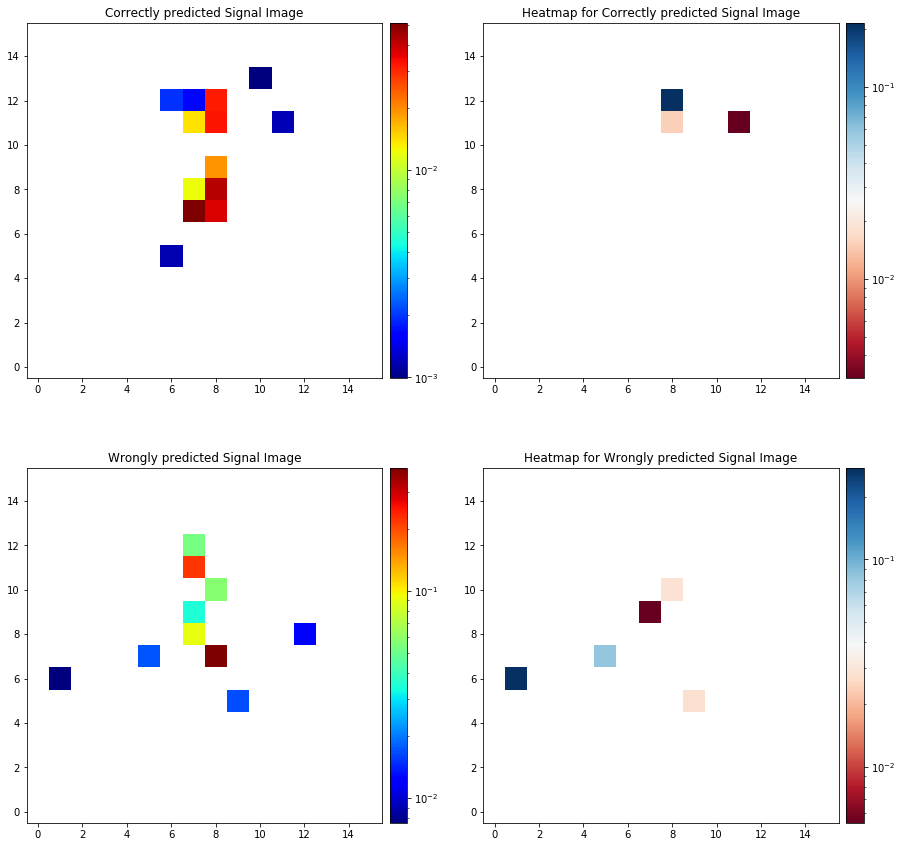

In [12]:
i=index1[35]
j=index2[94]

fig = plt.figure(figsize = (15,15))

ax1 = fig.add_subplot(221)
im = plt.imshow(signal_correct_pred[i].squeeze(), cmap='jet', interpolation='nearest', norm=LogNorm(), origin='low')
plt.colorbar(im,fraction=0.0467, pad=0.02)
plt.title('Correctly predicted Signal Image')

ax2 = fig.add_subplot(222)
im = plt.imshow(pixel_relevance[i].squeeze(), cmap='RdBu', interpolation='nearest', norm=LogNorm(), origin='low')
plt.colorbar(im,fraction=0.0467, pad=0.02)
plt.title('Heatmap for Correctly predicted Signal Image')

ax3 = fig.add_subplot(223)
im = plt.imshow(signal_wrong_pred[j].squeeze(), cmap='jet', interpolation='nearest', norm=LogNorm(), origin='low')
plt.colorbar(im,fraction=0.0467, pad=0.02)
plt.title('Wrongly predicted Signal Image')

ax4 = fig.add_subplot(224)
im = plt.imshow(pixel_relevance[j].squeeze(), cmap='RdBu', interpolation='nearest', norm=LogNorm(), origin='low')
plt.colorbar(im,fraction=0.0467, pad=0.02)
plt.title('Heatmap for Wrongly predicted Signal Image')

plt.show()

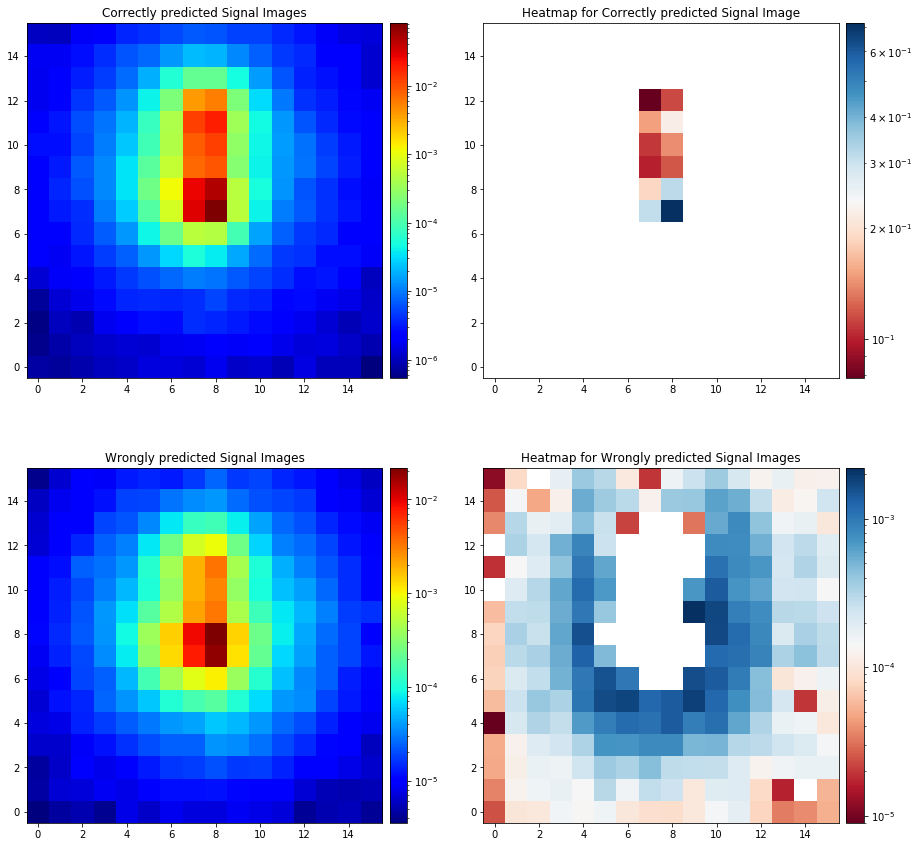

In [13]:
fig = plt.figure(figsize = (15,15))

ax1 = fig.add_subplot(221)
im = plt.imshow(np.average(signal_correct_pred, axis =0).squeeze(), cmap='jet', interpolation='nearest', norm=LogNorm(), origin='low')
plt.colorbar(im,fraction=0.0467, pad=0.02)
plt.title('Correctly predicted Signal Images')

ax2 = fig.add_subplot(222)
im = plt.imshow(np.average(pixel_relevance[index1], axis =0).squeeze(), cmap='RdBu', interpolation='nearest', norm=LogNorm(), origin='low')
plt.colorbar(im,fraction=0.0467, pad=0.02)
plt.title('Heatmap for Correctly predicted Signal Image')

ax3 = fig.add_subplot(223)
im = plt.imshow(np.average(signal_wrong_pred, axis =0).squeeze(), cmap='jet', interpolation='nearest', norm=LogNorm(), origin='low')
plt.colorbar(im,fraction=0.0467, pad=0.02)
plt.title('Wrongly predicted Signal Images')

ax4 = fig.add_subplot(224)
im = plt.imshow(np.average(pixel_relevance[index2], axis =0).squeeze(), cmap='RdBu', interpolation='nearest', norm=LogNorm(), origin='low')
plt.colorbar(im,fraction=0.0467, pad=0.02)
plt.title('Heatmap for Wrongly predicted Signal Images')
plt.show()

## Plots for Background

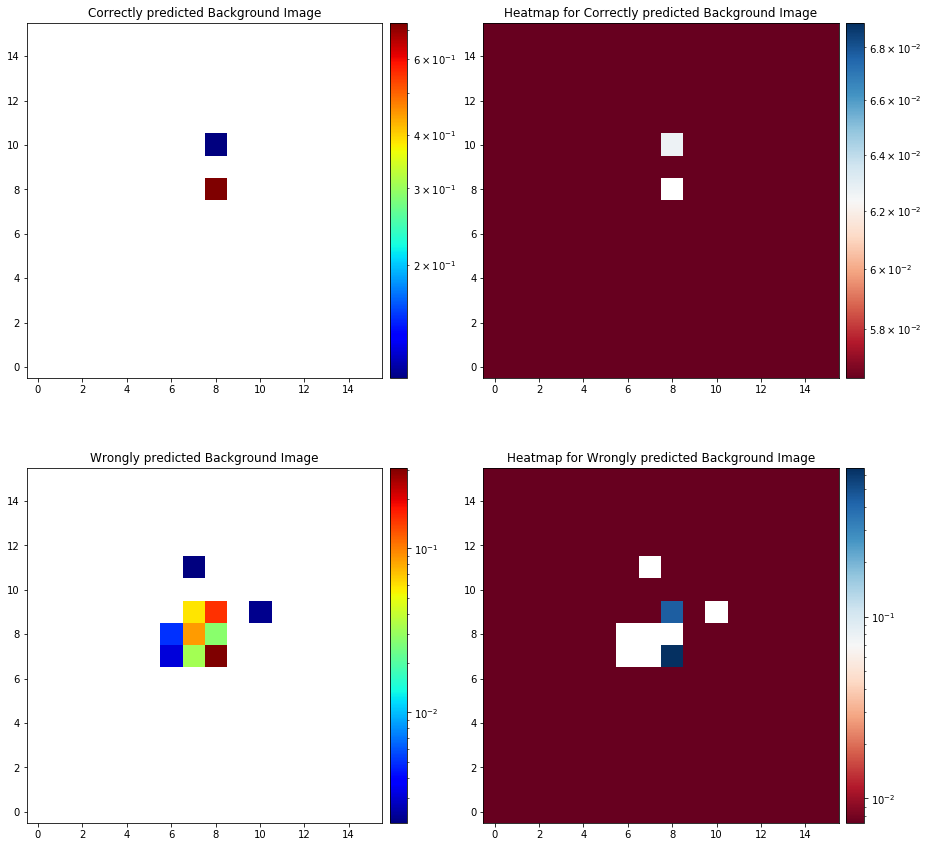

In [14]:
i =index3[0]
j=index4[10]

fig = plt.figure(figsize = (15,15))

ax1 = fig.add_subplot(221)
im = plt.imshow(bkg_correct_pred[i].squeeze(), cmap='jet', interpolation='nearest', norm=LogNorm(), origin='low')
plt.colorbar(im,fraction=0.0467, pad=0.02)
plt.title('Correctly predicted Background Image')

ax2 = fig.add_subplot(222)
im = plt.imshow(pixel_relevance[i].squeeze(), cmap='RdBu', interpolation='nearest', norm=LogNorm(), origin='low')
plt.colorbar(im,fraction=0.0467, pad=0.02)
plt.title('Heatmap for Correctly predicted Background Image')

ax3 = fig.add_subplot(223)
im = plt.imshow(bkg_wrong_pred[j].squeeze(), cmap='jet', interpolation='nearest', norm=LogNorm(), origin='low')
plt.colorbar(im,fraction=0.0467, pad=0.02)
plt.title('Wrongly predicted Background Image')

ax4 = fig.add_subplot(224)
im = plt.imshow(pixel_relevance[j].squeeze(), cmap='RdBu', interpolation='nearest', norm=LogNorm(), origin='low')
plt.colorbar(im,fraction=0.0467, pad=0.02)
plt.title('Heatmap for Wrongly predicted Background Image')

plt.show()

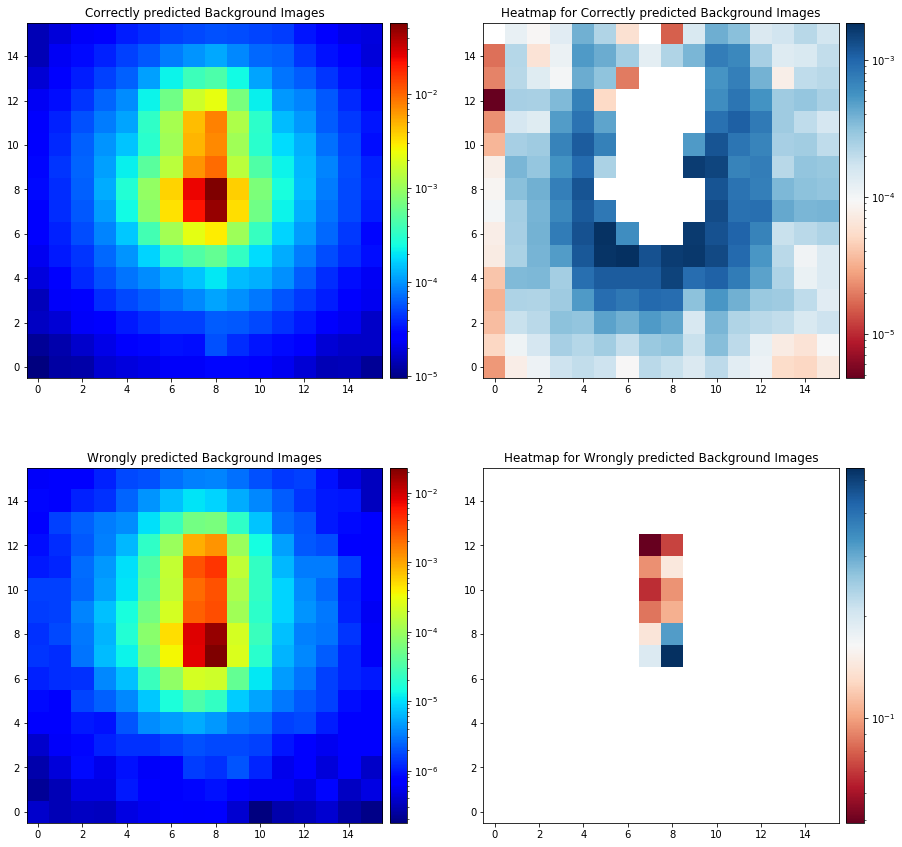

In [15]:
fig = plt.figure(figsize = (15,15))

ax1 = fig.add_subplot(221)
im = plt.imshow(np.average(bkg_correct_pred, axis =0).squeeze(), cmap='jet', interpolation='nearest', norm=LogNorm(), origin='low')
plt.colorbar(im,fraction=0.0467, pad=0.02)
plt.title('Correctly predicted Background Images')

ax2 = fig.add_subplot(222)
im = plt.imshow(np.average(pixel_relevance[index3], axis =0).squeeze(), cmap='RdBu', interpolation='nearest', norm=LogNorm(), origin='low')
plt.colorbar(im,fraction=0.0467, pad=0.02)
plt.title('Heatmap for Correctly predicted Background Images')

ax3 = fig.add_subplot(223)
im = plt.imshow(np.average(bkg_wrong_pred, axis =0).squeeze(), cmap='jet', interpolation='nearest', norm=LogNorm(), origin='low')
plt.colorbar(im,fraction=0.0467, pad=0.02)
plt.title('Wrongly predicted Background Images')

ax4 = fig.add_subplot(224)
im = plt.imshow(np.average(pixel_relevance[index4], axis =0).squeeze(), cmap='RdBu', interpolation='nearest', norm=LogNorm(), origin='low')
plt.colorbar(im,fraction=0.0467, pad=0.02)
plt.title('Heatmap for Wrongly predicted Background Images')
plt.show()

# LRP-$\epsilon$

In [16]:
e_pixel_relevance = GetRelevance(image_model, "lrp.epsilon", test_images)

time =  358.64413261413574


## Plots for Signal

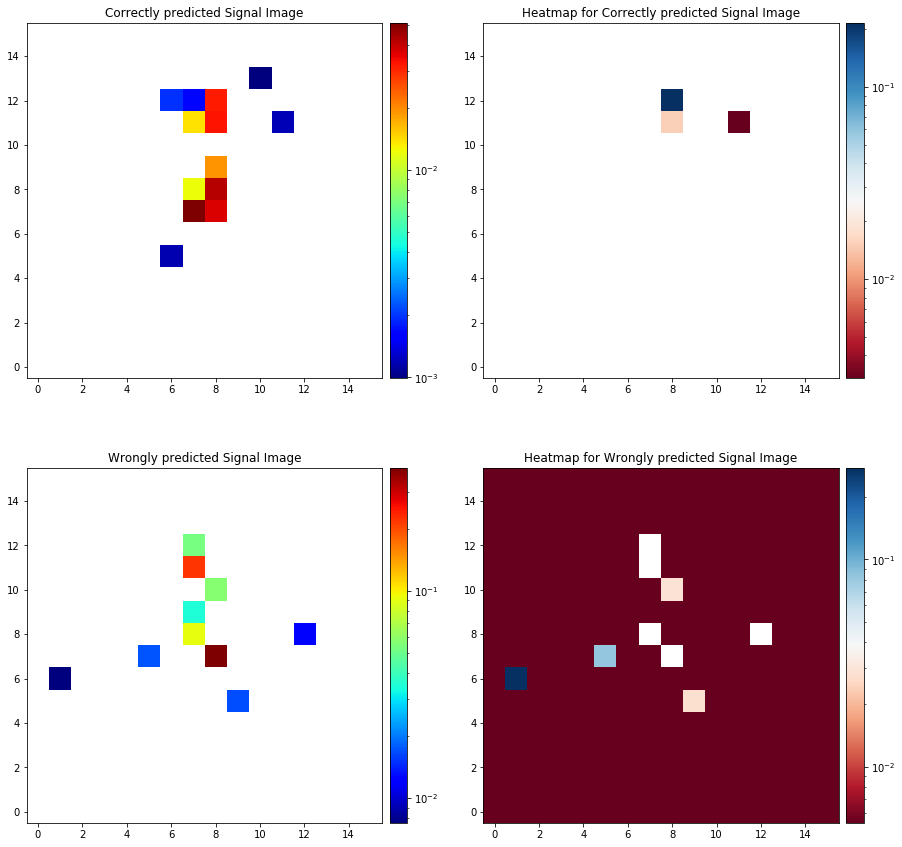

In [17]:
i=index1[35]
j=index2[94]

fig = plt.figure(figsize = (15,15))

ax1 = fig.add_subplot(221)
im = plt.imshow(signal_correct_pred[i].squeeze(), cmap='jet', interpolation='nearest', norm=LogNorm(), origin='low')
plt.colorbar(im,fraction=0.0467, pad=0.02)
plt.title('Correctly predicted Signal Image')

ax2 = fig.add_subplot(222)
im = plt.imshow(e_pixel_relevance[i].squeeze(), cmap='RdBu', interpolation='nearest', norm=LogNorm(), origin='low')
plt.colorbar(im,fraction=0.0467, pad=0.02)
plt.title('Heatmap for Correctly predicted Signal Image')

ax3 = fig.add_subplot(223)
im = plt.imshow(signal_wrong_pred[j].squeeze(), cmap='jet', interpolation='nearest', norm=LogNorm(), origin='low')
plt.colorbar(im,fraction=0.0467, pad=0.02)
plt.title('Wrongly predicted Signal Image')

ax4 = fig.add_subplot(224)
im = plt.imshow(e_pixel_relevance[j].squeeze(), cmap='RdBu', interpolation='nearest', norm=LogNorm(), origin='low')
plt.colorbar(im,fraction=0.0467, pad=0.02)
plt.title('Heatmap for Wrongly predicted Signal Image')

plt.show()

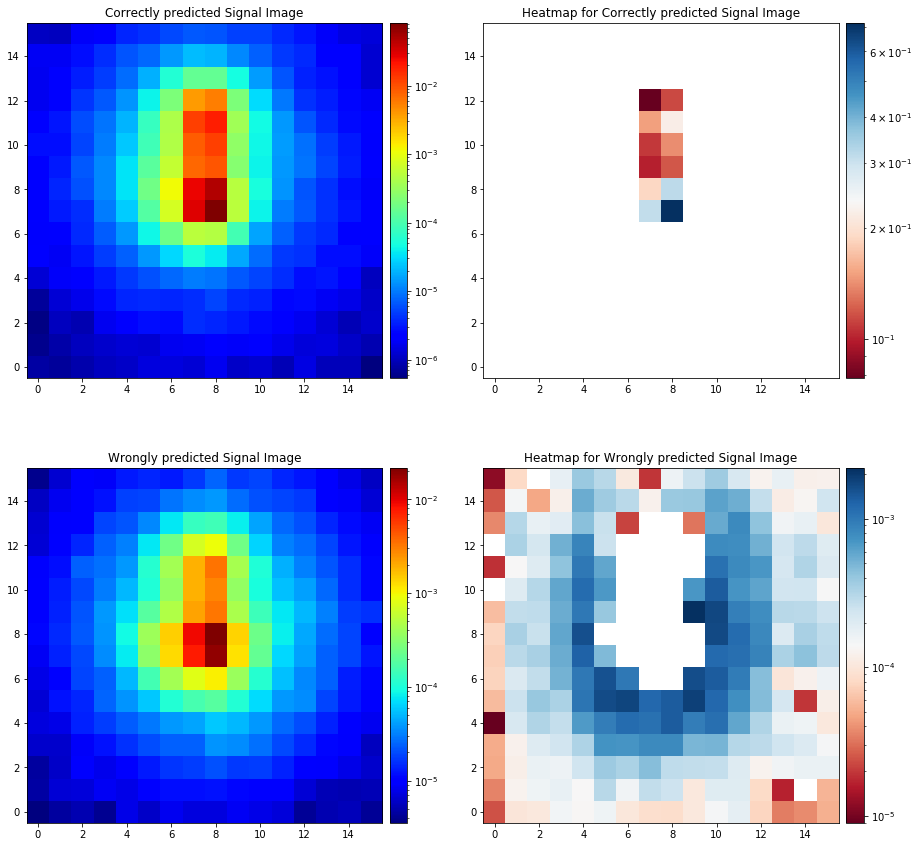

In [18]:
fig = plt.figure(figsize = (15,15))

ax1 = fig.add_subplot(221)
im = plt.imshow(np.average(signal_correct_pred, axis =0).squeeze(), cmap='jet', interpolation='nearest', norm=LogNorm(), origin='low')
plt.colorbar(im,fraction=0.0467, pad=0.02)
plt.title('Correctly predicted Signal Image')

ax2 = fig.add_subplot(222)
im = plt.imshow(np.average(e_pixel_relevance[index1], axis =0).squeeze(), cmap='RdBu', interpolation='nearest', norm=LogNorm(), origin='low')
plt.colorbar(im,fraction=0.0467, pad=0.02)
plt.title('Heatmap for Correctly predicted Signal Image')

ax3 = fig.add_subplot(223)
im = plt.imshow(np.average(signal_wrong_pred, axis =0).squeeze(), cmap='jet', interpolation='nearest', norm=LogNorm(), origin='low')
plt.colorbar(im,fraction=0.0467, pad=0.02)
plt.title('Wrongly predicted Signal Image')

ax4 = fig.add_subplot(224)
im = plt.imshow(np.average(e_pixel_relevance[index2], axis =0).squeeze(), cmap='RdBu', interpolation='nearest', norm=LogNorm(), origin='low')
plt.colorbar(im,fraction=0.0467, pad=0.02)
plt.title('Heatmap for Wrongly predicted Signal Image')
plt.show()

## Plots for Background

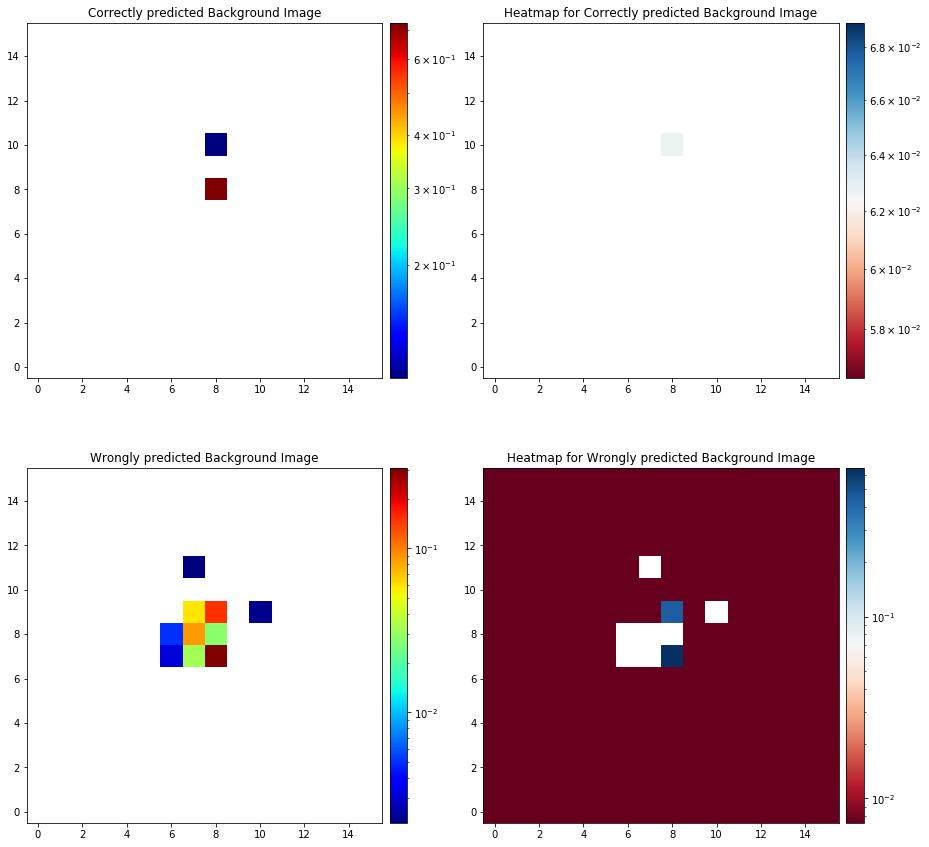

In [19]:
i =index3[0]
j=index4[10]

fig = plt.figure(figsize = (15,15))

ax1 = fig.add_subplot(221)
im = plt.imshow(bkg_correct_pred[i].squeeze(), cmap='jet', interpolation='nearest', norm=LogNorm(), origin='low')
plt.colorbar(im,fraction=0.0467, pad=0.02)
plt.title('Correctly predicted Background Image')

ax2 = fig.add_subplot(222)
im = plt.imshow(e_pixel_relevance[i].squeeze(), cmap='RdBu', interpolation='nearest', norm=LogNorm(), origin='low')
plt.colorbar(im,fraction=0.0467, pad=0.02)
plt.title('Heatmap for Correctly predicted Background Image')

ax3 = fig.add_subplot(223)
im = plt.imshow(bkg_wrong_pred[j].squeeze(), cmap='jet', interpolation='nearest', norm=LogNorm(), origin='low')
plt.colorbar(im,fraction=0.0467, pad=0.02)
plt.title('Wrongly predicted Background Image')

ax4 = fig.add_subplot(224)
im = plt.imshow(e_pixel_relevance[j].squeeze(), cmap='RdBu', interpolation='nearest', norm=LogNorm(), origin='low')
plt.colorbar(im,fraction=0.0467, pad=0.02)
plt.title('Heatmap for Wrongly predicted Background Image')

plt.show()

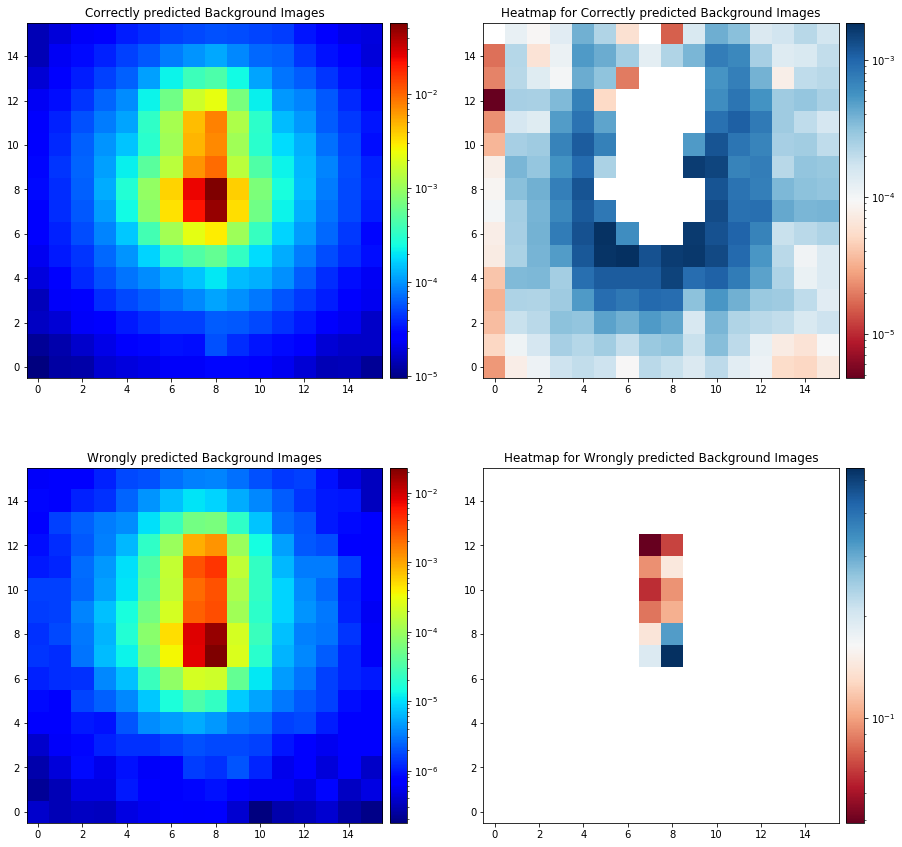

In [20]:
fig = plt.figure(figsize = (15,15))

ax1 = fig.add_subplot(221)
im = plt.imshow(np.average(bkg_correct_pred, axis =0).squeeze(), cmap='jet', interpolation='nearest', norm=LogNorm(), origin='low')
plt.colorbar(im,fraction=0.0467, pad=0.02)
plt.title('Correctly predicted Background Images')

ax2 = fig.add_subplot(222)
im = plt.imshow(np.average(e_pixel_relevance[index3], axis =0).squeeze(), cmap='RdBu', interpolation='nearest', norm=LogNorm(), origin='low')
plt.colorbar(im,fraction=0.0467, pad=0.02)
plt.title('Heatmap for Correctly predicted Background Images')

ax3 = fig.add_subplot(223)
im = plt.imshow(np.average(bkg_wrong_pred, axis =0).squeeze(), cmap='jet', interpolation='nearest', norm=LogNorm(), origin='low')
plt.colorbar(im,fraction=0.0467, pad=0.02)
plt.title('Wrongly predicted Background Images')

ax4 = fig.add_subplot(224)
im = plt.imshow(np.average(e_pixel_relevance[index4], axis =0).squeeze(), cmap='RdBu', interpolation='nearest', norm=LogNorm(), origin='low')
plt.colorbar(im,fraction=0.0467, pad=0.02)
plt.title('Heatmap for Wrongly predicted Background Images')
plt.show()

# LRP-$\gamma$ or LRP-$\alpha$ $_1$ $\beta$ $_0$

In [21]:
g_pixel_relevance = GetRelevance(image_model, "lrp.alpha_1_beta_0", test_images)

time =  530.1669585704803


## Plots for Signal

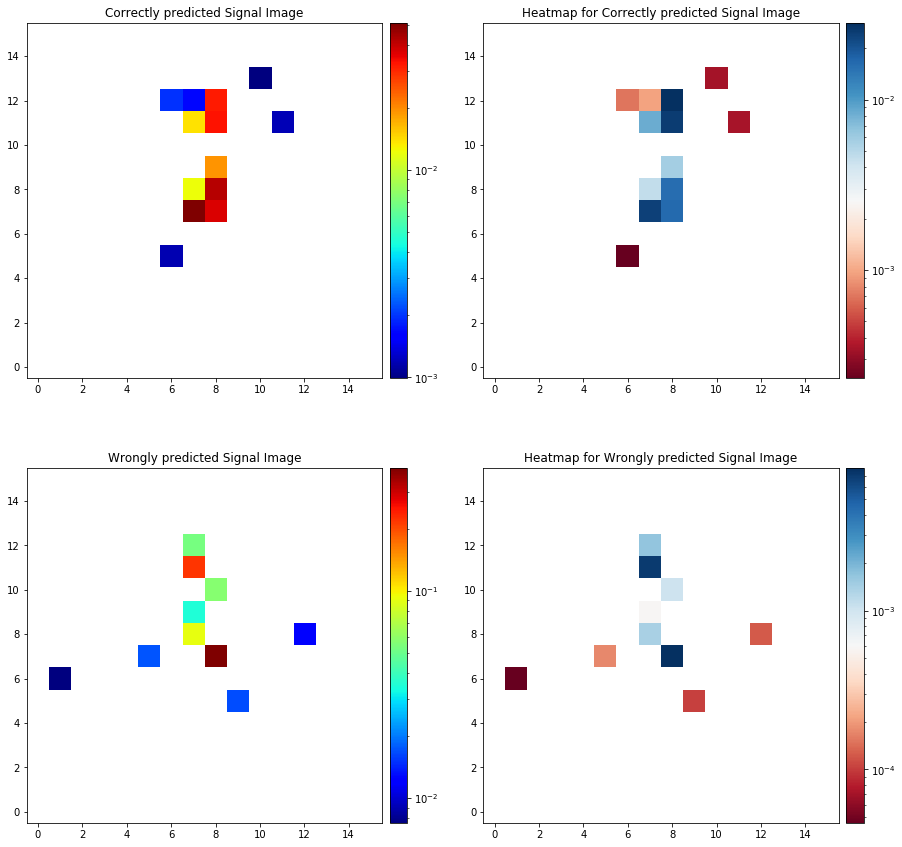

In [22]:
i=index1[35]
j=index2[94]

fig = plt.figure(figsize = (15,15))

ax1 = fig.add_subplot(221)
im = plt.imshow(signal_correct_pred[i].squeeze(), cmap='jet', interpolation='nearest', norm=LogNorm(), origin='low')
plt.colorbar(im,fraction=0.0467, pad=0.02)
plt.title('Correctly predicted Signal Image')

ax2 = fig.add_subplot(222)
im = plt.imshow(g_pixel_relevance[i].squeeze(), cmap='RdBu', interpolation='nearest', norm=LogNorm(), origin='low')
plt.colorbar(im,fraction=0.0467, pad=0.02)
plt.title('Heatmap for Correctly predicted Signal Image')

ax3 = fig.add_subplot(223)
im = plt.imshow(signal_wrong_pred[j].squeeze(), cmap='jet', interpolation='nearest', norm=LogNorm(), origin='low')
plt.colorbar(im,fraction=0.0467, pad=0.02)
plt.title('Wrongly predicted Signal Image')

ax4 = fig.add_subplot(224)
im = plt.imshow(g_pixel_relevance[j].squeeze(), cmap='RdBu', interpolation='nearest', norm=LogNorm(), origin='low')
plt.colorbar(im,fraction=0.0467, pad=0.02)
plt.title('Heatmap for Wrongly predicted Signal Image')

plt.show()

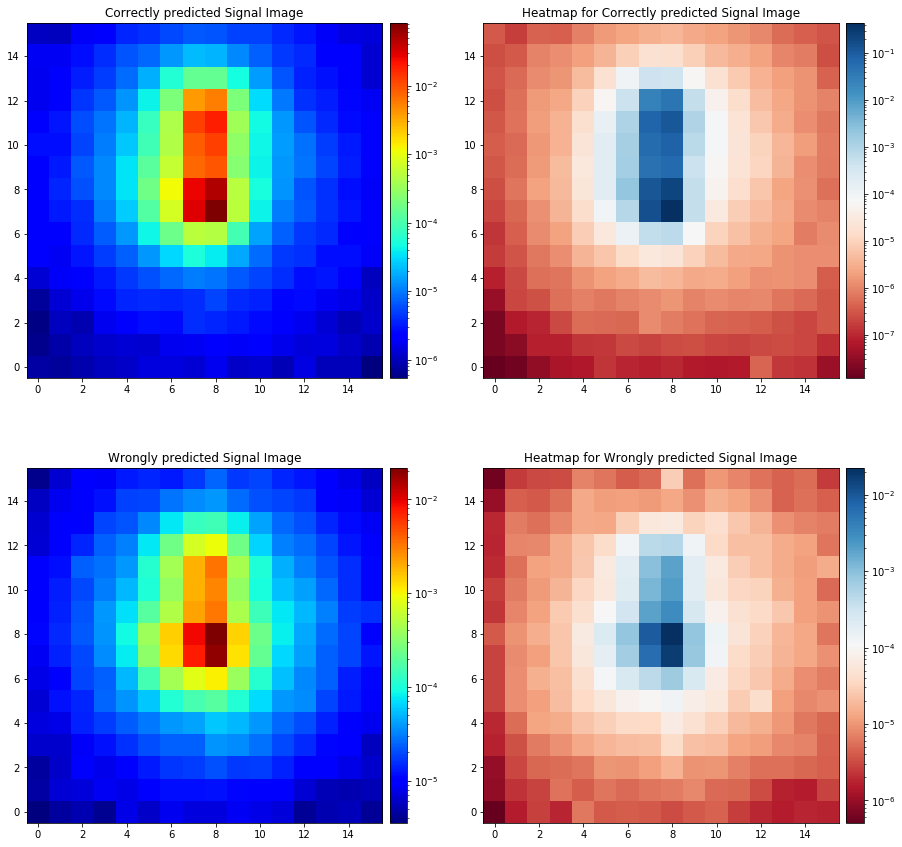

In [23]:
fig = plt.figure(figsize = (15,15))

ax1 = fig.add_subplot(221)
im = plt.imshow(np.average(signal_correct_pred, axis =0).squeeze(), cmap='jet', interpolation='nearest', norm=LogNorm(), origin='low')
plt.colorbar(im,fraction=0.0467, pad=0.02)
plt.title('Correctly predicted Signal Image')

ax2 = fig.add_subplot(222)
im = plt.imshow(np.average(g_pixel_relevance[index1], axis =0).squeeze(), cmap='RdBu', interpolation='nearest', norm=LogNorm(), origin='low')
plt.colorbar(im,fraction=0.0467, pad=0.02)
plt.title('Heatmap for Correctly predicted Signal Image')

ax3 = fig.add_subplot(223)
im = plt.imshow(np.average(signal_wrong_pred, axis =0).squeeze(), cmap='jet', interpolation='nearest', norm=LogNorm(), origin='low')
plt.colorbar(im,fraction=0.0467, pad=0.02)
plt.title('Wrongly predicted Signal Image')

ax4 = fig.add_subplot(224)
im = plt.imshow(np.average(g_pixel_relevance[index2], axis =0).squeeze(), cmap='RdBu', interpolation='nearest', norm=LogNorm(), origin='low')
plt.colorbar(im,fraction=0.0467, pad=0.02)
plt.title('Heatmap for Wrongly predicted Signal Image')
plt.show()

## Plots for Bkg

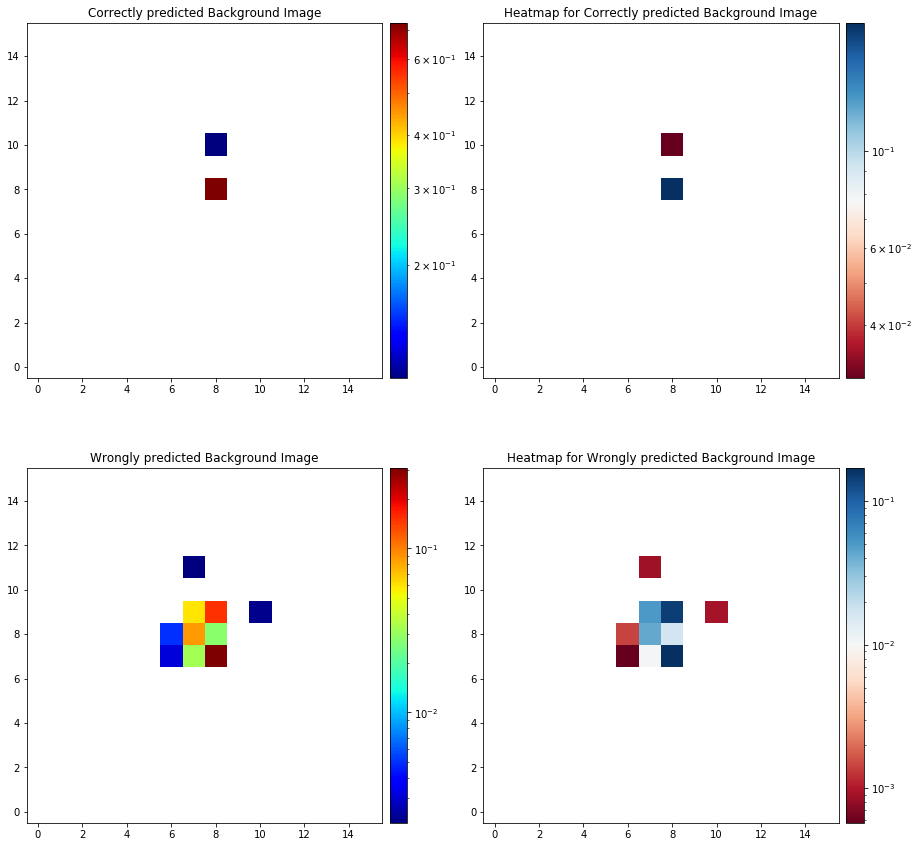

In [24]:
i =index3[0]
j=index4[10]

fig = plt.figure(figsize = (15,15))

ax1 = fig.add_subplot(221)
im = plt.imshow(bkg_correct_pred[i].squeeze(), cmap='jet', interpolation='nearest', norm=LogNorm(), origin='low')
plt.colorbar(im,fraction=0.0467, pad=0.02)
plt.title('Correctly predicted Background Image')

ax2 = fig.add_subplot(222)
im = plt.imshow(g_pixel_relevance[i].squeeze(), cmap='RdBu', interpolation='nearest', norm=LogNorm(), origin='low')
plt.colorbar(im,fraction=0.0467, pad=0.02)
plt.title('Heatmap for Correctly predicted Background Image')

ax3 = fig.add_subplot(223)
im = plt.imshow(bkg_wrong_pred[j].squeeze(), cmap='jet', interpolation='nearest', norm=LogNorm(), origin='low')
plt.colorbar(im,fraction=0.0467, pad=0.02)
plt.title('Wrongly predicted Background Image')

ax4 = fig.add_subplot(224)
im = plt.imshow(g_pixel_relevance[j].squeeze(), cmap='RdBu', interpolation='nearest', norm=LogNorm(), origin='low')
plt.colorbar(im,fraction=0.0467, pad=0.02)
plt.title('Heatmap for Wrongly predicted Background Image')

plt.show()

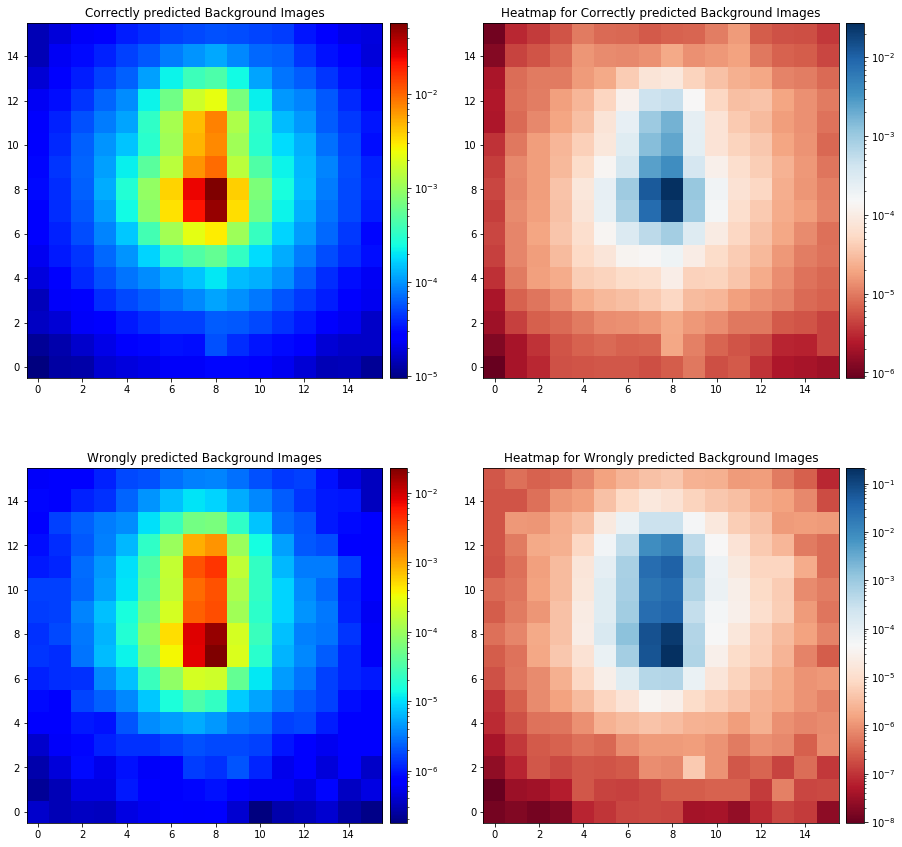

In [25]:
fig = plt.figure(figsize = (15,15))

ax1 = fig.add_subplot(221)
im = plt.imshow(np.average(bkg_correct_pred, axis =0).squeeze(), cmap='jet', interpolation='nearest', norm=LogNorm(), origin='low')
plt.colorbar(im,fraction=0.0467, pad=0.02)
plt.title('Correctly predicted Background Images')

ax2 = fig.add_subplot(222)
im = plt.imshow(np.average(g_pixel_relevance[index3], axis =0).squeeze(), cmap='RdBu', interpolation='nearest', norm=LogNorm(), origin='low')
plt.colorbar(im,fraction=0.0467, pad=0.02)
plt.title('Heatmap for Correctly predicted Background Images')

ax3 = fig.add_subplot(223)
im = plt.imshow(np.average(bkg_wrong_pred, axis =0).squeeze(), cmap='jet', interpolation='nearest', norm=LogNorm(), origin='low')
plt.colorbar(im,fraction=0.0467, pad=0.02)
plt.title('Wrongly predicted Background Images')

ax4 = fig.add_subplot(224)
im = plt.imshow(np.average(g_pixel_relevance[index4], axis =0).squeeze(), cmap='RdBu', interpolation='nearest', norm=LogNorm(), origin='low')
plt.colorbar(im,fraction=0.0467, pad=0.02)
plt.title('Heatmap for Wrongly predicted Background Images')
plt.show()